import numpy as np
import pandas as pd


In [88]:
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

custom_palette = ['#10002B', '#240046', '#3C096C', '#5A189A', '#7B2CBF', '#9D4EDD', '#C77DFF', '#E0AAFF']
custom_palette_reverse = custom_palette.reverse()
sns.set_palette(custom_palette_reverse)

In [58]:
data_path = os.path.join('..', 'data', 'DCCC.csv')
data = pd.read_csv(data_path, header=1)
data.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)
data.rename(columns={'PAY_2': 'PAY_1'}, inplace=True)
data.rename(columns={'PAY_3': 'PAY_2'}, inplace=True)
data.rename(columns={'PAY_4': 'PAY_3'}, inplace=True)
data.rename(columns={'PAY_5': 'PAY_4'}, inplace=True)
data.rename(columns={'PAY_6': 'PAY_5'}, inplace=True)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Missing Data Exploration and Handling


In [59]:
data.shape

(30000, 25)

In [60]:
for col in data.columns:
    num_missing = data[col].isnull().sum()
    num_unique = data[col].nunique()
    num_total = data.shape[0]
    print(f'{col} has {num_unique} unique values and {(num_missing/num_total)*100:.2f}% of the data is missing.')

ID has 30000 unique values and 0.00% of the data is missing.
LIMIT_BAL has 81 unique values and 0.00% of the data is missing.
SEX has 2 unique values and 0.00% of the data is missing.
EDUCATION has 7 unique values and 0.00% of the data is missing.
MARRIAGE has 4 unique values and 0.00% of the data is missing.
AGE has 56 unique values and 0.00% of the data is missing.
PAY_0 has 11 unique values and 0.00% of the data is missing.
PAY_1 has 11 unique values and 0.00% of the data is missing.
PAY_2 has 11 unique values and 0.00% of the data is missing.
PAY_3 has 11 unique values and 0.00% of the data is missing.
PAY_4 has 10 unique values and 0.00% of the data is missing.
PAY_5 has 10 unique values and 0.00% of the data is missing.
BILL_AMT1 has 22723 unique values and 0.00% of the data is missing.
BILL_AMT2 has 22346 unique values and 0.00% of the data is missing.
BILL_AMT3 has 22026 unique values and 0.00% of the data is missing.
BILL_AMT4 has 21548 unique values and 0.00% of the data is m

In [61]:
categorical_columns = ['SEX','EDUCATION', 'MARRIAGE']
categorical_columns += [f'PAY_{i}' for i in range(0,6)]
for col in categorical_columns:
    print(f'Unique Values in {col}:', sorted(data[col].unique()))

Unique Values in SEX: [1, 2]
Unique Values in EDUCATION: [0, 1, 2, 3, 4, 5, 6]
Unique Values in MARRIAGE: [0, 1, 2, 3]
Unique Values in PAY_0: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
Unique Values in PAY_1: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
Unique Values in PAY_2: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
Unique Values in PAY_3: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
Unique Values in PAY_4: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
Unique Values in PAY_5: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]


In [62]:
data['EDUCATION'].replace({0:4, 5:4, 6:4}, inplace=True)
data['MARRIAGE'].replace({0:3}, inplace=True)

pay_columns = [f'PAY_{i}' for i in range(0, 6)]
for col in pay_columns:
    data[col].replace({-2:-1, -1:0, 0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9}, inplace=True)
for col in categorical_columns:
    print(f"Unique Values in '{col}' updated to:", sorted(data[col].unique()))

Unique Values in 'SEX' updated to: [1, 2]
Unique Values in 'EDUCATION' updated to: [1, 2, 3, 4]
Unique Values in 'MARRIAGE' updated to: [1, 2, 3]
Unique Values in 'PAY_0' updated to: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique Values in 'PAY_1' updated to: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique Values in 'PAY_2' updated to: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique Values in 'PAY_3' updated to: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique Values in 'PAY_4' updated to: [-1, 0, 1, 3, 4, 5, 6, 7, 8, 9]
Unique Values in 'PAY_5' updated to: [-1, 0, 1, 3, 4, 5, 6, 7, 8, 9]


In [63]:

for col in categorical_columns:
    data[col] = data[col].astype('category')

In [64]:
X = data.drop('DEFAULT', axis=1)
y = data['DEFAULT']

## Exploratory Analysis


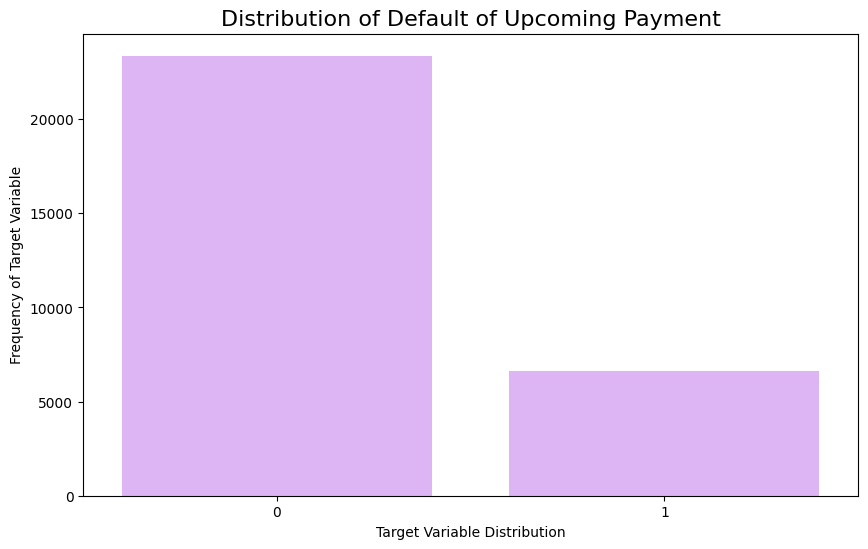

In [85]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='DEFAULT')
plt.title('Distribution of Default of Upcoming Payment', fontsize=16)
plt.xlabel('Target Variable Distribution')
plt.ylabel('Frequency of Target Variable')
plt.show()

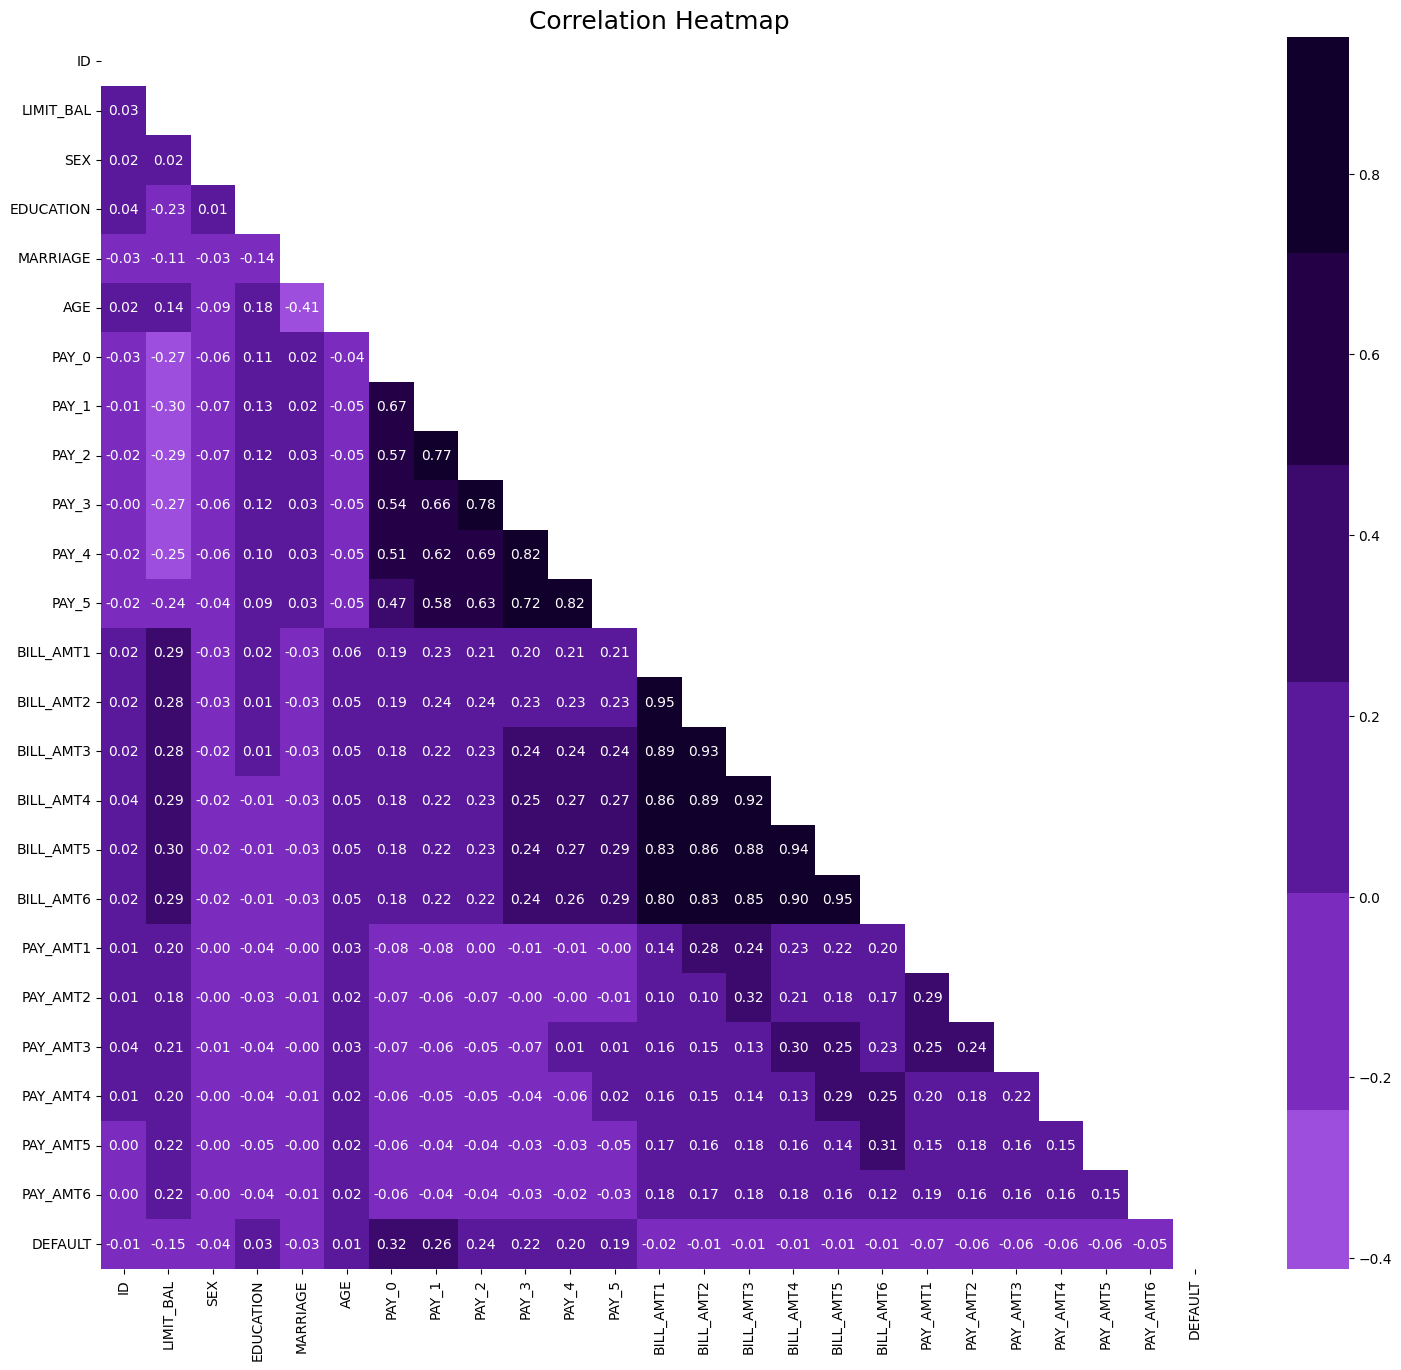

In [82]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = LinearSegmentedColormap.from_list('custom_heatmap', custom_palette, N=256)
plt.figure(figsize=(18, 16))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=custom_palette, center=0)
plt.title('Correlation Heatmap', fontsize=18)
plt.show()

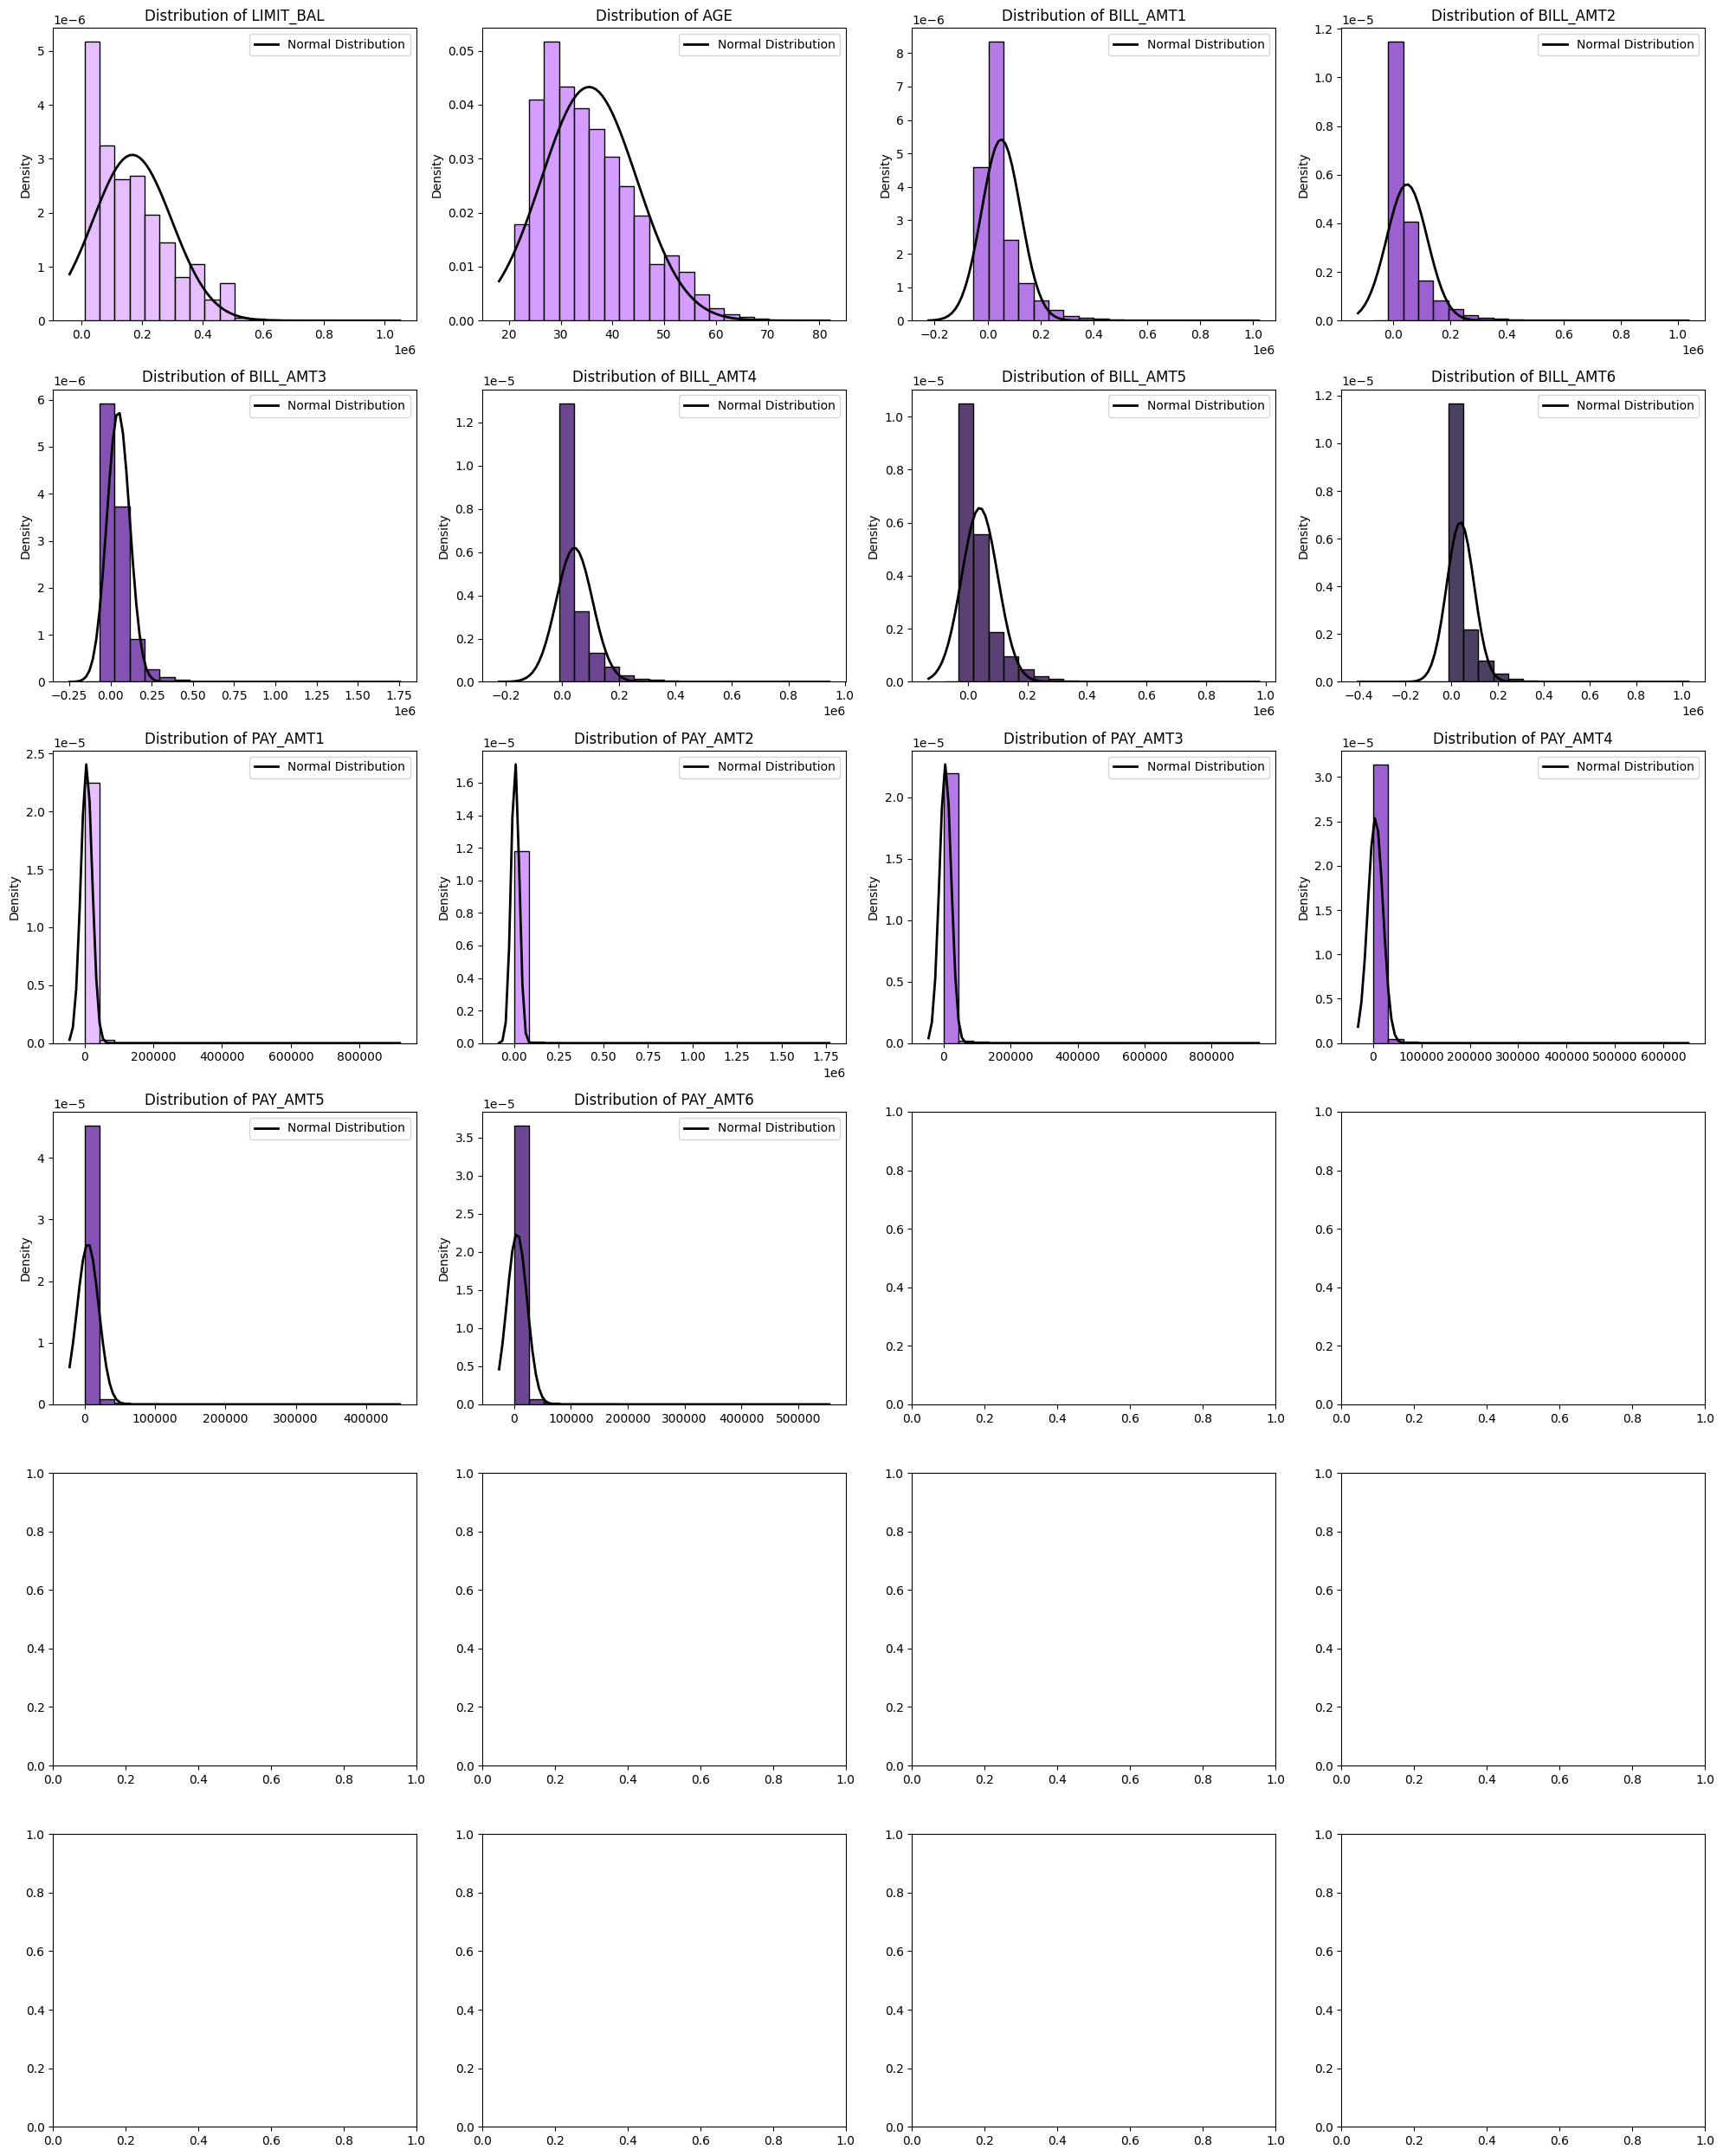

In [91]:
numerical_features = ['LIMIT_BAL', 'AGE'] + [f'BILL_AMT{i}' for i in range(1, 7)] + [f'PAY_AMT{i}' for i in range(1, 7)]
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 25))
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.histplot(data[col], bins=20, ax=axes[i], color=custom_palette[i % len(custom_palette)], stat="density", edgecolor='black')
    mu, std = norm.fit(data[col])
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[i].plot(x, p, 'k', linewidth=2, label='Normal Distribution')
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')
    axes[i].legend()
plt.tight_layout()
plt.show()